# Simple Exploratory Data Analysis on financial data

## Objective of the notebook
- import and visual financial data using [OpenBB](https://docs.openbb.co/odp/python/reference) and [mlfinpy](https://mlfinpy.readthedocs.io/en/latest/): 

In [50]:
# Main imports

import datetime 
from openbb import obb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [51]:
# load relevant data
output = obb.equity.price.historical("AAPL")
df = output.to_dataframe()
rename_map = {c: c.capitalize() for c in df.columns}
df = df.rename(columns=rename_map)

In [52]:
# check data
df.head()

,Open,High,Low,Close,Volume,Dividend
date,,,,,,
2025-02-03,229.990005,231.830002,225.699997,228.009995,73063300,0.0
2025-02-04,227.250000,233.130005,226.649994,232.800003,45067300,0.0
2025-02-05,228.529999,232.669998,228.270004,232.470001,39620300,0.0
2025-02-06,231.289993,233.800003,230.429993,233.220001,29925300,0.0
2025-02-07,232.600006,234.000000,227.259995,227.630005,39707200,0.0


In [53]:
# Transform index into proper dates
df.index = pd.to_datetime(df.index)

In [54]:
def simple_plot(df: pd.DataFrame, parameter_to_plot: str) -> None:
    plt.figure(figsize=(15,5))
    sns.lineplot(df[parameter_to_plot])
    plt.xlabel('Date')
    plt.ylabel(parameter_to_plot)
    plt.show()
    plt.style.use("dark_background")

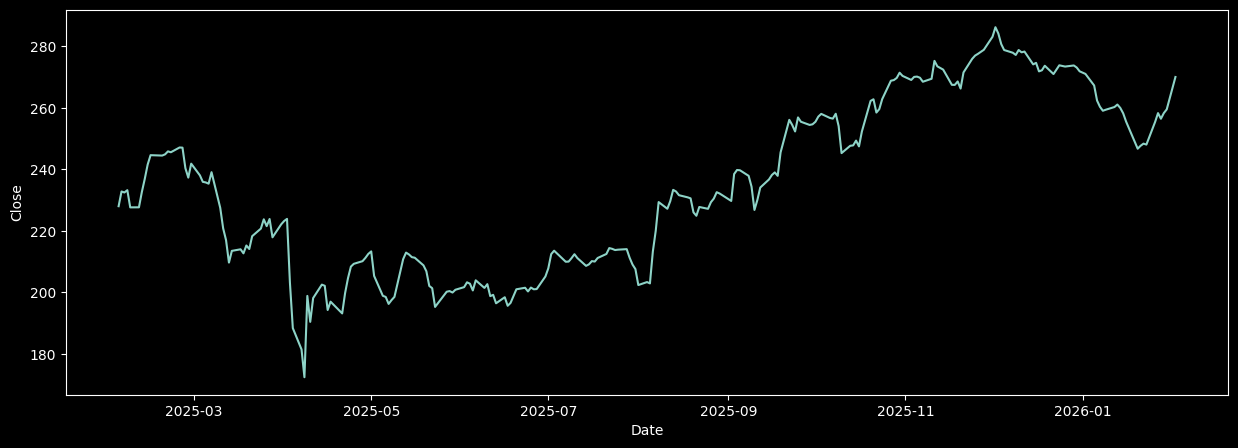

In [55]:
# Simple plot of the price across time
simple_plot(df, 'Close')

In [56]:
def add_basic_ohlc_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["log_close"] = np.log(out["Close"].astype(float))
    out["logret_cc"] = out["log_close"].diff()
    out["ret_cc"] = out["Close"].astype(float).pct_change()

    out["logret_oc"] = np.log(out["Close"].astype(float) / out["Open"].astype(float))
    out["logret_overnight"] = np.log(out["Open"].astype(float) / out["Close"].astype(float).shift(1))

    out["hl_log_range"] = np.log(out["High"].astype(float) / out["Low"].astype(float))
    out["tr"] = np.maximum(
        (out["High"] - out["Low"]).abs(),
        np.maximum((out["High"] - out["Close"].shift(1)).abs(),
                   (out["Low"] - out["Close"].shift(1)).abs())
    )
    out["atr_14"] = out["tr"].rolling(14).mean()
    return out

df_feat = add_basic_ohlc_features(df)
df_feat[["logret_cc", "hl_log_range", "atr_14"]].tail()


,logret_cc,hl_log_range,atr_14
date,,,
2026-01-27,0.011135,0.014381,5.365002
2026-01-28,-0.007111,0.016947,5.399288
2026-01-29,0.007150,0.020387,5.442859
2026-01-30,0.004635,0.037820,5.852146
2026-02-02,0.039779,0.042616,6.336789


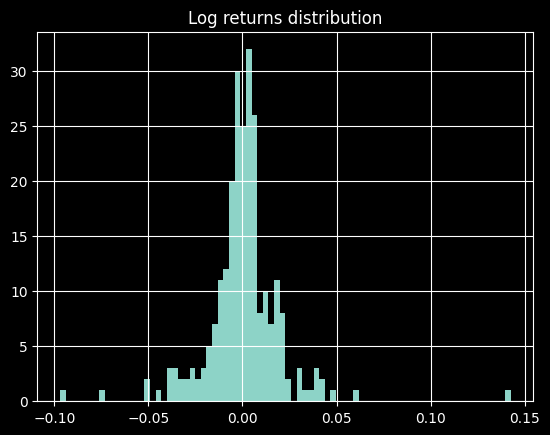

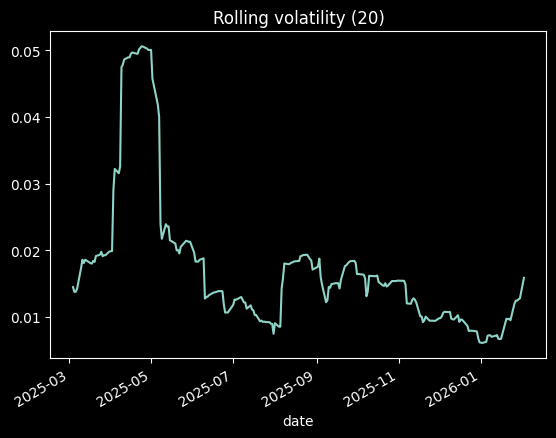

In [57]:
df_feat["logret_cc"].hist(bins=80)
plt.title("Log returns distribution")
plt.show()

df_feat["logret_cc"].rolling(20).std().plot()
plt.title("Rolling volatility (20)")
plt.show()


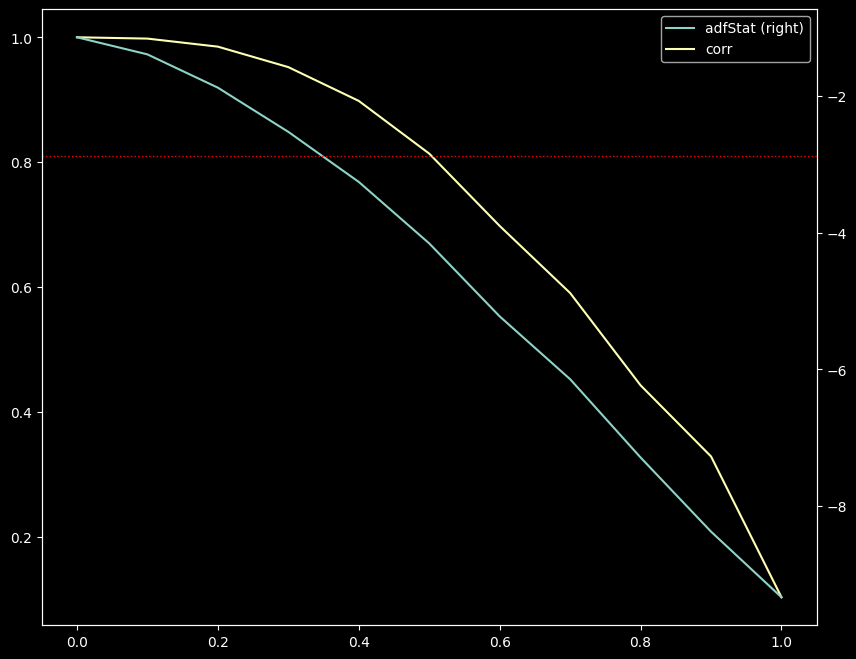

In [58]:
from mlfinpy.util.frac_diff import plot_min_ffd
from mlfinpy.util.frac_diff import frac_diff_ffd

close_df = df_feat[["Close"]].astype(float).rename(columns={"Close": "close"})

plot_min_ffd(close_df)

fd = frac_diff_ffd(close_df, diff_amt=0.5, thresh=1e-5)
df_feat["close_fd_0p5"] = fd["close"]


In [59]:
fd = frac_diff_ffd(close_df, diff_amt=0.3, thresh=1e-3)
df_feat["close_fd"] = fd["close"]
df_feat[["Close", "close_fd"]].dropna().head()

,Close,close_fd
date,,
2025-05-07,196.250000,37.054469
2025-05-08,197.490005,39.590868
2025-05-09,198.529999,40.921135
2025-05-12,210.789993,53.191889
2025-05-13,212.929993,51.816088


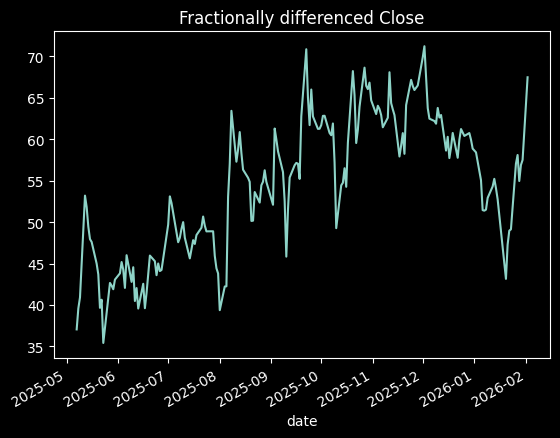

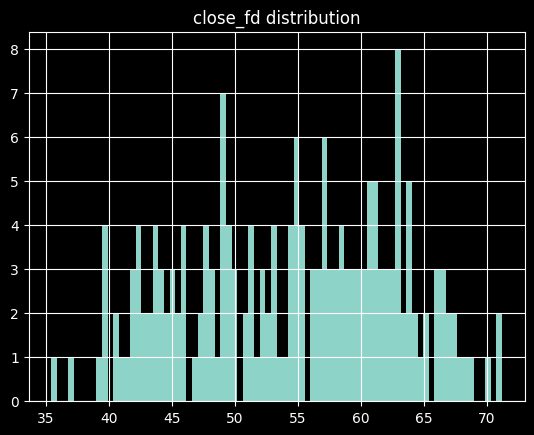

In [61]:

df_feat["close_fd"].plot(title="Fractionally differenced Close")
plt.show()

df_feat["close_fd"].dropna().hist(bins=80)
plt.title("close_fd distribution")
plt.show()


In [62]:
from statsmodels.tsa.stattools import adfuller

x = df_feat["close_fd"].dropna().values
adf_stat, pvalue, *_ = adfuller(x)
print("ADF stat:", adf_stat, "p-value:", pvalue)


ADF stat: -2.956072715977057 p-value: 0.039205304359562654


In [63]:
# TDA

In [64]:
signal = df_feat["close_fd"].dropna().astype(float)
x = signal.values

In [69]:
from gtda.time_series import SingleTakensEmbedding

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_embeddings=30,     # window length m
    time_delay=1,        # tau
    dimension=3,         # embedding dimension
    stride=1
)

X = embedder.fit_transform(x)
print(X.shape)  # (n_windows, dimension)


ImportError: cannot import name 'get_chunk_n_rows' from 'sklearn.utils' (/Users/sbourgeat/Projects/Quant/TopoQuant/.venv/lib/python3.11/site-packages/sklearn/utils/__init__.py)